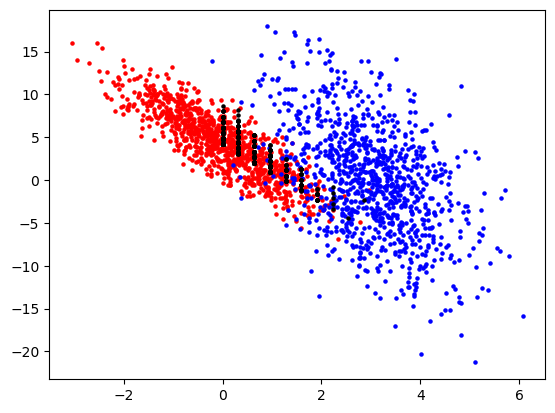

In [173]:
# data shifting and correction

import torch
import matplotlib.pyplot as plt

def synthetic_dataset(w, b, randn_source, distribution):
    X = distribution(randn_source) / torch.pi
    y = torch.matmul(X, w) + b  # generate labels
    y += torch.normal(0, 0.01, y.shape)  # tune labels a little bit
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
n_samples = 1000

# create poison train dataset
train_X, train_y = synthetic_dataset(true_w, true_b, torch.rand(n_samples, len(true_w)) * 3, torch.poisson)

# create normal test dataset
test_X = torch.normal(0, 1, size=(n_samples, len(true_w)))
test_y = torch.matmul(test_X, true_w) + true_b
test_y += torch.normal(0, 0.1, test_y.shape)
test_y = test_y.reshape((-1, 1))

test_X2 = torch.normal(3, 1, size=(n_samples, len(true_w)))
test_y2 = torch.matmul(test_X2, true_w) + true_b
test_y2 += torch.normal(0, 5, test_y2.shape)
test_y2 = test_y2.reshape((-1, 1))

plt.scatter(test_X[:, 1].detach().numpy(), test_y.detach().numpy(), 5, color='red')
plt.scatter(test_X2[:, 1].detach().numpy(), test_y2.detach().numpy(), 5, color='blue')
plt.scatter(train_X[:, 1].detach().numpy(), train_y.detach().numpy(), 5, color='black')

import random
from d2l import torch as d2l

# mini-batch
batch_size = 100
def mini_batch(X, y, batch_size):
    num_examples = len(X)
    indices = list(range(num_examples))
    random.shuffle(indices)
    features, labels = [], []
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])
        features.append(X[batch_indices])
        labels.append(y[batch_indices])
    return features, labels

train_X, train_y = mini_batch(train_X, train_y, batch_size)
test_X, test_y = mini_batch(test_X, test_y, batch_size)
test_X2, test_y2 = mini_batch(test_X2, test_y2, batch_size)

In [181]:
# original train and test
# -----------------------

# parameters initialization
w = torch.normal(0 ,0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# model 
def linearRegression(X):
    return torch.matmul(X, w) + b

# loss
def MSE(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# optimizer
def optimizer(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size  # update w and b with learning rate and batch size
            param.grad.zero_()                              # reduction of gradient

# accuracy
def accuracy(y_hat, y):
    difference = y_hat.type(y.dtype) - y
    return sum(difference) / len(difference)

# train 
n_epochs = 20
lr = 0.005
def train_test(net, features, labels, n_epochs, loss, optimizer, is_training=True):
    accuracy_epoch = []
    loss_epoch = []
    for epoch in range(n_epochs):
        accuracy_batch = []
        loss_batch = []
        for i, (X, y) in enumerate(zip(features, labels)):
            y_hat = net(X)
            accuracy_batch.append(accuracy(y_hat, y))
            if is_training == True:
                l = loss(y_hat, y)
                loss_batch.append(sum(l) / len(l))
                l.sum().backward()
                optimizer([w, b], lr, batch_size)
        a_avg = sum(accuracy_batch) / len(accuracy_batch)
        accuracy_epoch.append(a_avg)
        if is_training == True:
            l_avg = sum(loss_batch) / len(loss_batch)
            loss_epoch.append(l_avg)
            # print(a_avg, l_avg)
    if is_training == True:
        return accuracy_epoch, loss_epoch
    else:
        return accuracy_epoch

original_accuracy, original_loss = train_test(linearRegression, test_X2, test_y2, n_epochs, MSE, optimizer)
print(abs(sum(original_accuracy)/len(original_accuracy)))
print(sum(original_loss)/len(original_loss))
print(f'w estimated error: {true_w - w.reshape(true_w.shape)}')
print(f'b estimated error: {true_b - b}:f')

with torch.no_grad():
    original_test = train_test(linearRegression, test_X, test_y, n_epochs, MSE, optimizer, is_training=False)
    print(abs(sum(original_test)/len(original_test)))

tensor([0.1056], grad_fn=<AbsBackward0>)
tensor([16.4832], grad_fn=<DivBackward0>)
w estimated error: tensor([ 0.3973, -1.7123], grad_fn=<SubBackward0>)
b estimated error: tensor([4.0944], grad_fn=<RsubBackward1>):f
tensor([4.0981])


In [198]:
# did not completed

tensor([[1, 2, 3, 4],
        [2, 7, 6, 0]]) torch.Size([2, 4])
tensor([[10],
        [15]]) torch.Size([2, 1])
